## Aplicación métodos de exploración del dataset

Empezamos importando el dataset desde el repositorio del proyecto.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/SoraSpace769/CC5206_steam_games/GMatamoro/data/steam_ready2.csv')
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,appid,name,developer,publisher,price,year,duenos_promedio,rating_neto,rating_perc,Action,...,Casual,Simulation,Racing,Violent,Massively Multiplayer,Nudity,Sports,Early Access,Gore,Sexual Content
0,10,Counter-Strike,Valve,Valve,7801,2000,15000000.0,121195,0.973888,1,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,Valve,Valve,4329,1999,7500000.0,2685,0.839787,1,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,Valve,Valve,4329,2003,7500000.0,3018,0.895648,1,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,Valve,Valve,4329,2001,7500000.0,1006,0.826623,1,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,4329,1999,7500000.0,4962,0.947996,1,...,0,0,0,0,0,0,0,0,0,0


## Experimentos con el dataset

Para obtener un clustering óptimo para nuestro proyecto, tenemos que elegir correctamente:
* Los atributos que usaremos
* El método para normalizar los datos
* El algoritmo de clustering apropiado

Entonces debemos realizar varios experimentos probando con distintas formas de trabajar los datos:

### Experimento 1: (todos los datos numéricos),(normalización MinMax),(K-Means)
**1. Normalización de los datos**

In [2]:
from sklearn import preprocessing

df_numeric = df[["price","year","duenos_promedio","rating_neto","rating_perc"]]

# MinMax = x - min(x) / max(x) - min(x)

x = df_numeric.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_numeric = pd.DataFrame(x_scaled)
df_numeric.head()

,0,1,2,3,4
0,0.091023,0.136364,0.099940,0.057308,0.973888
1,0.050511,0.090909,0.049937,0.004633,0.839787
2,0.050511,0.272727,0.049937,0.004781,0.895648
3,0.050511,0.181818,0.049937,0.003887,0.826623
4,0.050511,0.090909,0.049937,0.005645,0.947996


**2. Obtener parámetro k y clusters**

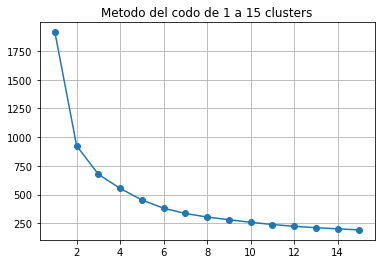

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt  

sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(df_numeric)
    sse.append(kmeans.inertia_)
plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

In [25]:
k=7
kmeans = KMeans(n_clusters=k).fit(df_numeric)
df_labels = kmeans.labels_
count_num = lambda num, arr: len(list(filter(lambda x: x==num, arr)))
for i in range(k):
    print('cluster '+str(i+1)+' = ' + str(count_num(i,df_labels)))

cluster 1 = 6430
cluster 2 = 4129
cluster 3 = 1502
cluster 4 = 5609
cluster 5 = 6796
cluster 6 = 1042
cluster 7 = 1405


**3. Reducción de dimensiones y aplicar algoritmo**

In [4]:
from sklearn.decomposition import PCA

new_df_numeric = PCA(n_components=2, random_state=0).fit_transform(df_numeric)

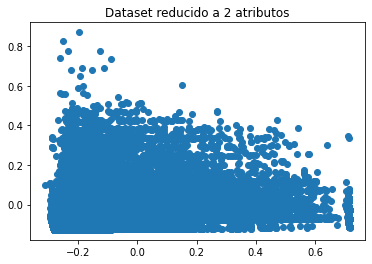

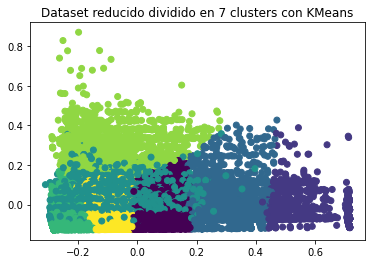

In [8]:
plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1])
plt.title("Dataset reducido a 2 atributos")
plt.show()

kmeans_new = KMeans(n_clusters=7).fit(new_df_numeric)
plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 7 clusters con KMeans")
plt.show()

**4. Resultados y observaciones**

Podemos ver muchos valores extraños, donde ciertos datos se encuentran dentro de otros clusters. Esto se puede deber al cambio drástico que el dataset sufre al reducir sus dimensiones, cosa que no sucedía tan claramente en experimentos hechos previamente en el curso, lo cual se puede deber a la naturaleza del dataset o también a que quizá la reducción de dimensiones usando `PCA` no es tan precisa, intentaremos usar otro método de la librería **decomposition** de **sklearn** llamado **_Singular Value Decomposition_**.. 

Primero podemos ver que cuando dividimos el dataset en clusters **después de reducir sus dimensiones** este problema se arregla (naturalmente). Luego intentamos nuevamente con `SVD` y observamos cómo cambia la distribución de los datos y si el problema mencionado anteriormente se presenta de igual manera.

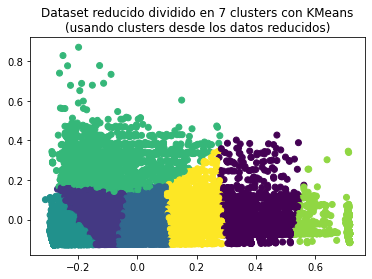

In [28]:
k=7

kmeans = KMeans(n_clusters=k).fit(new_df_numeric)
df_labels = kmeans.labels_

kmeans_new = KMeans(n_clusters=k).fit(new_df_numeric)
plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 7 clusters con KMeans\n(usando clusters desde los datos reducidos)")
plt.show()

In [29]:
from sklearn.decomposition import TruncatedSVD as TSVD
svd = TSVD(n_components=2, random_state=0).fit_transform(df_numeric.values)

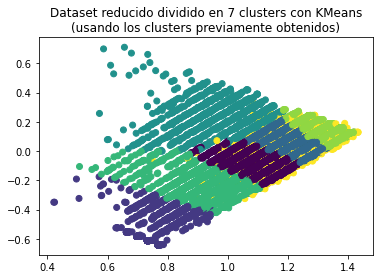

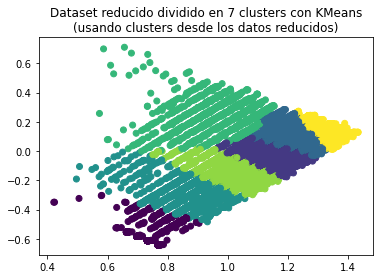

In [30]:
k=7

kmeans = KMeans(n_clusters=k).fit(df_numeric)
df_labels = kmeans.labels_

plt.scatter(svd[:, 0], svd[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 7 clusters con KMeans\n(usando los clusters previamente obtenidos)")
plt.show()

kmeans = KMeans(n_clusters=k).fit(svd)
df_labels = kmeans.labels_

plt.scatter(svd[:, 0], svd[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 7 clusters con KMeans\n(usando clusters desde los datos reducidos)")
plt.show()

Si bien por un lado aparecen muchos datos dispersos entre diferentes clusters, pareciera también que se redujo la aglomeración de los puntos. De cualquier manera, seguiremos observando otros experimentos, pero a partir de ahora **dividiremos los clusters después de reducir las dimensiones de los datos** para evitar evidentes problemas de clustering.

### Experimento 2: (normalización Z-score)

**1. Normalización de los datos** 

In [14]:
# Z-score (standardization) = x - mean(x) / std(x)

df_numeric = df[["price","year","duenos_promedio","rating_neto","rating_perc"]]
df_numeric =(df_numeric-df_numeric.mean())/df_numeric.std()
df_numeric.head()

,price,year,duenos_promedio,rating_neto,rating_perc
0,0.190166,-7.639879,11.167003,7.522544,1.110130
1,-0.303575,-8.102928,5.533092,0.118359,0.536096
2,-0.303575,-6.250734,5.533092,0.139164,0.775212
3,-0.303575,-7.176831,5.533092,0.013460,0.479746
4,-0.303575,-8.102928,5.533092,0.260620,0.999294


**2. Obtener parámetro k**

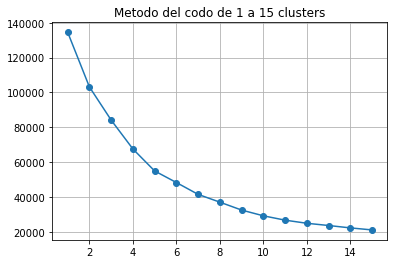

In [15]:
sse = []

clusters = list(range(1, 16))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(df_numeric)
    sse.append(kmeans.inertia_)
plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 15 clusters")
plt.grid(True)
plt.show()

**3. Reducción de dimensiones y aplicar algoritmo**

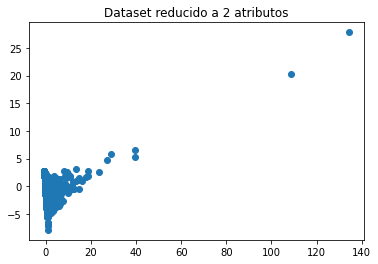

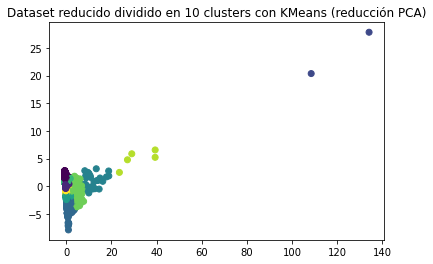

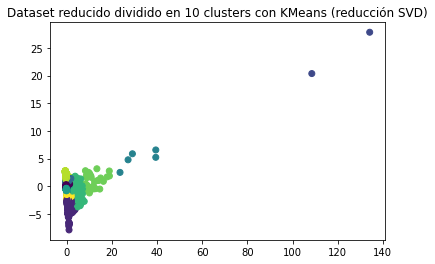

In [16]:
k=10

new_df_numeric = PCA(n_components=2, random_state=0).fit_transform(df_numeric)

kmeans = KMeans(n_clusters=k).fit(new_df_numeric)
df_labels = kmeans.labels_

plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1])
plt.title("Dataset reducido a 2 atributos")
plt.show()

plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 10 clusters con KMeans (reducción PCA)")
plt.show()

new_df_numeric = TSVD(n_components=2, random_state=0).fit_transform(df_numeric)

kmeans = KMeans(n_clusters=k).fit(new_df_numeric)
df_labels2 = kmeans.labels_

plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels2)
plt.title("Dataset reducido dividido en 10 clusters con KMeans (reducción SVD)")
plt.show()


**4. Resultados y observaciones**

Primero que todo, podemos apreciar que al usar la normalización Z-score los datos con los valores más extremos (que como veremos a continuación parecen corresponder a los juegos más populares) se alejan considerablemente de la aglomeración de los datos comunes. Esto podría ser beneficioso para nuestro objetivo de caracterizar estos juegos.

Lo segundo que podemos notar al usar Z-score es que al reducir las dimensiones del dataset usando los dos métodos antes vistos, obtenemos una distribución casi idéntica (si es que no idéntica). Esta consistencia es una buena señal para la exploración, así que seguiremos usándolo.

In [17]:
for i in range(k):
    print('cluster '+str(i+1)+' = ' + str(count_num(i,df_labels)))

cluster 1 = 2755
cluster 2 = 8564
cluster 3 = 2
cluster 4 = 523
cluster 5 = 32
cluster 6 = 2370
cluster 7 = 6598
cluster 8 = 218
cluster 9 = 5
cluster 10 = 5846


Pareciera que el 3er cluster se compone de dos outliers groseros, pero no es el caso. El problema es que se trata de los juegos `Counter-Strike: Global Offensive` y `Dota 2`, los cuales son precisamente los juegos más populares de la plataforma. 

Ahora, no podemos elminar estos datos, ya que para encontrar un modelo que represente los juegos más exitosos deberíamos llegar a clusters que agrupen a los juegos más populares considerando la posición de estos.

In [20]:
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 3:
        juegos.append(i)
df.iloc[juegos]

,appid,name,developer,publisher,price,year,duenos_promedio,rating_neto,rating_perc,Action,...,Casual,Simulation,Racing,Violent,Massively Multiplayer,Nudity,Sports,Early Access,Gore,Sexual Content
22,570,Dota 2,Valve,Valve,0,2013,150000000.0,721428,0.858710,1,...,0,0,0,0,0,0,0,0,0,0
25,730,Counter-Strike: Global Offensive,Valve;Hidden Path Entertainment,Valve,0,2012,75000000.0,2242091,0.867952,1,...,0,0,0,0,0,0,0,0,0,0


Aunque, si observamos los juegos del 5to y 9no cluster, podemos observar que generamos tres clusters de interés constituidos por varios juegos que de antemano sabemos que pueden ser considerados populares o exitosos. Esto puede significar que vamos por buen camino, quizás **una buena estrategia sería dividir el dataset en varios clusters y luego ir reagrupando los que no correspondan a los juegos más exitosos** para tener un mejor criterio de evaluación de los datos que pueda ser usado en el futuro. 

In [21]:
print("Juegos del 9no cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 9:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 9no cluster


19                     Team Fortress 2
120                        Garry's Mod
1630                          Warframe
3333                          Unturned
12746    PLAYERUNKNOWN'S BATTLEGROUNDS
Name: name, dtype: object

In [22]:
print("Juegos del 5to cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 5:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 5to cluster


0                        Counter-Strike
7        Counter-Strike: Condition Zero
9                           Half-Life 2
10               Counter-Strike: Source
13              Half-Life 2: Deathmatch
14              Half-Life 2: Lost Coast
17                               Portal
21                        Left 4 Dead 2
23                             Portal 2
221         Sid Meier's Civilization® V
902                       Borderlands 2
1024        The Elder Scrolls V: Skyrim
1118                           Terraria
1213                        Tomb Raider
1464                           PAYDAY 2
1592             Euro Truck Simulator 2
1603                  Heroes & Generals
1721                        War Thunder
1766                      Path of Exile
2007                               Rust
2022                     Rocket League®
2456                 Grand Theft Auto V
2924                            Warface
2925                         Brawlhalla
2937          The Witcher® 3: Wild Hunt


### Experimento 3: (- AÑOS),(múltiples clusters + aglomeración de comunes)

Para este experimento ya no consideramos el año de salida de los juegos, ya que si el objetivo del clustering es obtener agrupaciones para luego ser usadas en un modelo de clasificación predictivo, no tiene sentido pensar en el año de salida de juegos anteriores como alternativa para los proximos lanzamientos.

Incluiremos la variable usuarios promedio a pesar de su alta correlación con el rating neto. Esto es para evitar problemas ciertos problemas de clustering, ya que de lo contrario se pueden considerar juegos con pocos usuarios como similares a los más populares basado en su porcentaje de ratings positivos y su precio, en especial si son Free-2-Play.

Nuestro objetivo con este experimento es aplicar la estrategia planteada en la parte anterior.

**1. Normalización de los datos** 

In [43]:
# Z-score (standardization) = x - mean(x) / std(x)

df_numeric = df[["price","duenos_promedio","rating_neto","rating_perc"]]
df_numeric =(df_numeric-df_numeric.mean())/df_numeric.std()
df_numeric.head()

,price,duenos_promedio,rating_neto,rating_perc
0,0.190166,11.167003,7.522544,1.110130
1,-0.303575,5.533092,0.118359,0.536096
2,-0.303575,5.533092,0.139164,0.775212
3,-0.303575,5.533092,0.013460,0.479746
4,-0.303575,5.533092,0.260620,0.999294


**2. Obtener parámetro k** 

Aunque ya estamos determinados a obtener una alta cantidad de clusters, asi que usaremos un `k` bastante grande.

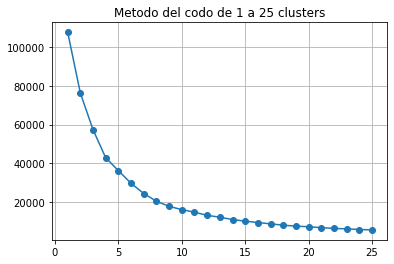

In [8]:
sse = []

clusters = list(range(1, 26))
for k in clusters:
    kmeans = KMeans(n_clusters=k).fit(df_numeric)
    sse.append(kmeans.inertia_)
plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 25 clusters")
plt.grid(True)
plt.show()

**3. Reducción de dimensiones y aplicar algoritmo**

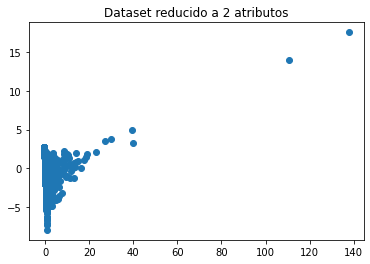

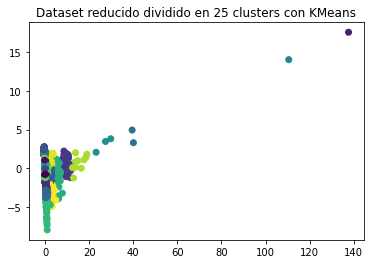

In [44]:
k=25

new_df_numeric = PCA(n_components=2, random_state=0).fit_transform(df_numeric.values)

plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1])
plt.title("Dataset reducido a 2 atributos")
plt.show()

kmeans = KMeans(n_clusters=k).fit(new_df_numeric)
df_labels = kmeans.labels_

plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels)
plt.title("Dataset reducido dividido en 25 clusters con KMeans")
plt.show()


**4. Resultados y observaciones**

A simple vista, todo el dataset menos los resultados más lejanos estan aglomerados. Pero a continuación veremos que si quitamos estos datos podemos observar los clusters bien definidos y ordenados apuntando al dato mayor. Esto es una muy buena señal, pero es necesario verificar observando los juegos que corresponden a estos clusters.

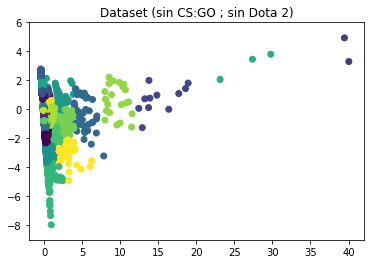

In [61]:
plt.scatter(new_df_numeric[:, 0], new_df_numeric[:, 1] , c=df_labels)
plt.title("Dataset (sin CS:GO ; sin Dota 2)")
plt.xlim(-2, 42)
plt.ylim(-9, 6)
plt.show()

In [45]:
# Almacenamos los indices de los datos por cluster

clusters = []
for i in range(k):
    clusters += [[]]
#     print('cluster '+str(i+1)+' = ' + str(count_num(i,df_labels)))
for i in range(len(df_labels)):
    x = df_labels[i]
    clusters[x] += [i]
for i in range(len(clusters)):
    print('cluster '+str(i+1)+' = '+ str(len(clusters[i])))

cluster 1 = 3548
cluster 2 = 2202
cluster 3 = 1
cluster 4 = 749
cluster 5 = 21
cluster 6 = 3816
cluster 7 = 589
cluster 8 = 91
cluster 9 = 348
cluster 10 = 2
cluster 11 = 1065
cluster 12 = 1
cluster 13 = 3
cluster 14 = 2808
cluster 15 = 3141
cluster 16 = 37
cluster 17 = 100
cluster 18 = 4534
cluster 19 = 1577
cluster 20 = 281
cluster 21 = 1657
cluster 22 = 11
cluster 23 = 199
cluster 24 = 82
cluster 25 = 50


Bajo la noción de que los clusters con menos datos (digamos, menos de 100) son los más alejados de la aglomeración, podemos artificialmente arreglar los clusters para generar "_tiers_" con los datos de la siguiente forma:

In [46]:
# enviamos todos los datos de clusters aglomerados a uno solo
cluster_comunes = []
for cl in list(clusters):
    if len(cl)>=100:
        cluster_comunes += cl
        clusters.remove(cl)
# creamos nuestro arreglo de clusters (lista de listas)
clusters_tier = []
# vamos agregando clusters de acuerdo a la cantidad de datos que contienen
# es vulnerable a colocar en desorden clusters del mismo tamaño
# pero no se espera que sea común fuera de los primeros lugares
for i in range(100):
    for j in clusters:
        if len(j)==i:
            clusters_tier += [j]
# agregamos al final el cluster del aglomerado
clusters_tier += [cluster_comunes]
for i in range(len(clusters_tier)):
    print('cluster '+str(i+1)+' = '+ str(len(clusters_tier[i])))

cluster 1 = 1
cluster 2 = 1
cluster 3 = 2
cluster 4 = 3
cluster 5 = 11
cluster 6 = 21
cluster 7 = 37
cluster 8 = 50
cluster 9 = 82
cluster 10 = 91
cluster 11 = 26614


In [47]:
print("Juegos del cluster 1:")
df.iloc[clusters_tier[0],1]

Juegos del cluster 1:


25    Counter-Strike: Global Offensive
Name: name, dtype: object

In [48]:
print("Juegos del cluster 2:")
df.iloc[clusters_tier[1],1]

Juegos del cluster 2:


22    Dota 2
Name: name, dtype: object

In [49]:
print("Juegos del cluster 3:")
df.iloc[clusters_tier[2],1]

Juegos del cluster 3:


19                     Team Fortress 2
12746    PLAYERUNKNOWN'S BATTLEGROUNDS
Name: name, dtype: object

In [50]:
print("Juegos del cluster 4:")
df.iloc[clusters_tier[3],1]

Juegos del cluster 4:


120     Garry's Mod
1630       Warframe
3333       Unturned
Name: name, dtype: object

In [51]:
print("Juegos del cluster 5:")
df.iloc[clusters_tier[4],1]

Juegos del cluster 5:


0                        Counter-Strike
21                        Left 4 Dead 2
23                             Portal 2
1024        The Elder Scrolls V: Skyrim
1118                           Terraria
1464                           PAYDAY 2
2022                     Rocket League®
2456                 Grand Theft Auto V
2937          The Witcher® 3: Wild Hunt
5198    Tom Clancy's Rainbow Six® Siege
8069                          Paladins®
Name: name, dtype: object

In [52]:
print("Juegos del cluster 6:")
df.iloc[clusters_tier[5],1]

Juegos del cluster 6:


7       Counter-Strike: Condition Zero
9                          Half-Life 2
10              Counter-Strike: Source
13             Half-Life 2: Deathmatch
14             Half-Life 2: Lost Coast
17                              Portal
221        Sid Meier's Civilization® V
902                      Borderlands 2
1213                       Tomb Raider
1592            Euro Truck Simulator 2
1603                 Heroes & Generals
1721                       War Thunder
1766                     Path of Exile
2007                              Rust
2924                           Warface
2925                        Brawlhalla
3223                         Robocraft
3755       Life is Strange - Episode 1
3834             Don't Starve Together
6003                  Dead by Daylight
7752                  Z1 Battle Royale
Name: name, dtype: object

In [53]:
print("Juegos del cluster 7:")
df.iloc[clusters_tier[6],1]

Juegos del cluster 7:


6                               Half-Life
12                  Day of Defeat: Source
16               Half-Life 2: Episode One
18               Half-Life 2: Episode Two
20                            Left 4 Dead
218                     BioShock Infinite
257      Call of Duty®: Modern Warfare® 2
481                    Fallout: New Vegas
894                Mount & Blade: Warband
1125                               Arma 3
1137                          Neverwinter
1373                            Starbound
1461                         PlanetSide 2
1476           Chivalry: Medieval Warfare
1505                 Age of Empires II HD
1522                           Insurgency
1543                 No More Room in Hell
1649                      Killing Floor 2
1771                          Dying Light
1811                           The Forest
1954        The Binding of Isaac: Rebirth
2076                     Cities: Skylines
2291                           Subnautica
2579               A Story About M

In [54]:
print("Juegos del cluster 8:")
df.iloc[clusters_tier[7],1]

Juegos del cluster 8:


779                                 Serious Sam 3: BFE
800                           Call of Duty®: Black Ops
887                                        The Sims™ 3
929                     Warhammer 40,000: Space Marine
1117          Age of Empires® III: Complete Collection
1211                       Call of Duty®: Black Ops II
1223                                 Crusader Kings II
1244                Sins of a Solar Empire: Rebellion®
1395                  South Park™: The Stick of Truth™
1405                                  Alien: Isolation
1418             Total War™: ROME II - Emperor Edition
1488                              Kerbal Space Program
1492                                DmC: Devil May Cry
1502                                              DayZ
1659                                    Shadow Warrior
1669                                  Prison Architect
1722                                    DARK SOULS™ II
1730                             Europa Universalis IV
2096      

Observando estas categorías y teniendo en cuenta nuestro conocimiento general sobre videojuegos, podemos decir que este algoritmo de clustering es bastante acertado al agrupar a los juegos más populares. Sin embargo, vale la pena probar distintos métodos de clustering. 

### Experimento 4: (DBSCAN)

Usaremos el método de clustering DBSCAN en esta ocasión, aunque no esperamos resultados muy positivos ya que ahora no podemos manipular directamente la cantidad de clusters que obtendremos y tendremos problemas al aplicar nuestra estrategia. Pero aun así, vale la pena intentarlo.

**1. Normalización de los datos** 

In [32]:
# Z-score (standardization) = x - mean(x) / std(x)

df_numeric = df[["price","duenos_promedio","rating_neto","rating_perc"]]
df_numeric =(df_numeric-df_numeric.mean())/df_numeric.std()
df_numeric.head()

,price,duenos_promedio,rating_neto,rating_perc
0,0.190166,11.167003,7.522544,1.110130
1,-0.303575,5.533092,0.118359,0.536096
2,-0.303575,5.533092,0.139164,0.775212
3,-0.303575,5.533092,0.013460,0.479746
4,-0.303575,5.533092,0.260620,0.999294


**2. Obtener parámetros _eps_ y _min samples_**

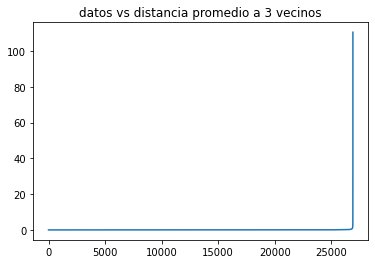

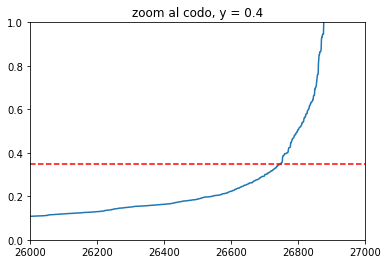

In [33]:
from sklearn.neighbors import NearestNeighbors

neigh = 3

nbrs = NearestNeighbors(n_neighbors=neigh).fit(df_numeric)
distances, indices = nbrs.kneighbors(df_numeric)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title(f"datos vs distancia promedio a {neigh} vecinos")
plt.plot(distances)
plt.show()

# lmao, hacemos zoom al codo
plt.title("zoom al codo, y = 0.4")
plt.plot(distances)
plt.xlim(26000, 27000)
plt.ylim(0, 1)
plt.axhline(y=0.35, color='r', linestyle='--')
plt.show()

**3. Reducción de dimensiones y aplicar algoritmo**

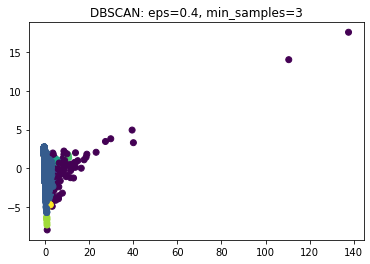

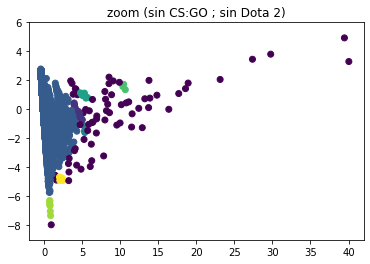

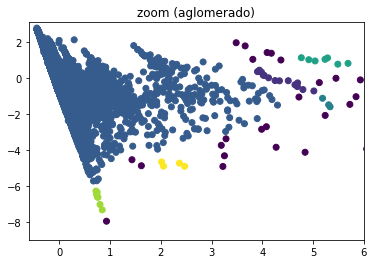

In [34]:
from sklearn.cluster import DBSCAN

new_df_numeric = PCA(n_components=2, random_state=0).fit_transform(df_numeric.values)

eps = 0.4
min_samples = 3

dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(new_df_numeric)
plt.scatter(new_df_numeric[:,0], new_df_numeric[:,1], c=dbscan.labels_)
plt.title(f"DBSCAN: eps={eps}, min_samples={min_samples}")
plt.show()

plt.scatter(new_df_numeric[:,0], new_df_numeric[:,1], c=dbscan.labels_)
plt.title("zoom (sin CS:GO ; sin Dota 2)")
plt.xlim(-2, 42)
plt.ylim(-9, 6)
plt.show()

plt.scatter(new_df_numeric[:,0], new_df_numeric[:,1], c=dbscan.labels_)
plt.title("zoom (aglomerado)")
plt.xlim(-0.6, 6)
plt.ylim(-9, 3.1)
plt.show()

**4. Resultados y observaciones**

In [36]:
df_labels = dbscan.labels_
n_clusters = len(set(df_labels)) - (1 if -1 in df_labels else 0)
n_noise = list(df_labels).count(-1)
print("total clusters: "+str(n_clusters))
print("datos ruido: "+str(n_noise))
print("")
for i in range(n_clusters):
    print('cluster '+str(i+1)+' = ' + str(count_num(i,df_labels)))

total clusters: 7
datos ruido: 70

cluster 1 = 14
cluster 2 = 26805
cluster 3 = 3
cluster 4 = 7
cluster 5 = 3
cluster 6 = 7
cluster 7 = 4


In [37]:
print("Juegos del 1er cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 1:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 1er cluster


1               Team Fortress Classic
2                       Day of Defeat
3                  Deathmatch Classic
4           Half-Life: Opposing Force
5                            Ricochet
8               Half-Life: Blue Shift
12              Day of Defeat: Source
16           Half-Life 2: Episode One
18           Half-Life 2: Episode Two
20                        Left 4 Dead
481                Fallout: New Vegas
1373                        Starbound
1954    The Binding of Isaac: Rebirth
2579           A Story About My Uncle
Name: name, dtype: object

In [38]:
print("Juegos del 3er cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 3:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 3er cluster


218                   BioShock Infinite
257    Call of Duty®: Modern Warfare® 2
894              Mount & Blade: Warband
Name: name, dtype: object

In [39]:
print("Juegos del 4to cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 4:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 4to cluster


1461             PlanetSide 2
1543     No More Room in Hell
3311                    Trove
4188              Dirty Bomb®
5352           Clicker Heroes
6195                   SMITE®
11704             Black Squad
Name: name, dtype: object

In [40]:
print("Juegos del 5to cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 5:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 5to cluster


1721      War Thunder
1766    Path of Exile
2925       Brawlhalla
Name: name, dtype: object

In [41]:
print("Juegos del 6to cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 6:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 6to cluster


3806           Command: Modern Air / Naval Operations WOTY
5630                        Gary Grigsby's War in the East
9226         Crazy Stone Deep Learning -The First Edition-
12124                                          Emission VR
14723                       Gary Grigsby's War in the West
18149    <U+6700><U+5F37><U+306E><U+56F2><U+7881> ~<U+5...
23564                                          Cine Tracer
Name: name, dtype: object

In [42]:
print("Juegos del 7mo cluster")
juegos = []
for i in range(len(df_labels)):
    if df_labels[i]+1 == 7:
        juegos.append(i)
df.iloc[juegos,1]

Juegos del 7mo cluster


12878           Assassin's Creed® Origins
13509                     Devil May Cry 5
20633           Assassin's Creed® Odyssey
22987    RESIDENT EVIL 2 / BIOHAZARD RE:2
Name: name, dtype: object

DBSCANS claramente no es un método de clustering que nos sirva para nuestra exploración, ya que la mayoría de los datos en el dataset original son poco relevantes y se encuentran aglomerados, generando un cluster dominante. Esto en sí no es mucho problema, es más, uno pensaría que equivale al paso en nuestra estrategia de juntar los clusters poco relevantes, sin embargo esto implica que una gran cantidad de los datos de juegos más relevantes (como CS:GO y Dota 2) son catalogados como ruido (Noise Points) ya que se encuentran a una gran distancia entre ellos en comparación a los datos del aglomerado.

Esto es culpa de la naturaleza del algoritmo mismo. Si observamos el gráfico en la parte **2.** de este experimento, lo que sucede es que los datos a la derecha del punto de inflexión corresponden a los juegos de interés, aquellos que componen las _tiers_ más altas del experimento anterior. Por esto, este algoritmo no nos resultó útil para obtener agrupaciones definidas y significativas de los datos del dataset.  

## Resultados preeliminares

Pudimos llegar en el experimento 3 a una división del dataset en clusters de interés, básicamente separando a los juegos más exitosos en un sistema de _tiers_ ordenadas de acuerdo a la popularidad de los juegos con cierta precisión. 

Para evaluar este clustering nos basamos exclusivamente en nuestros conocimientos previos sobre los juegos en vez de usar métodos numéricos, porque lo que buscamos principalmente es categorizar los juegos más populares para observar sus atributos no-numéricos y atribuirle a los datos una variable _target_ para generar una clasificación predictiva.

In [93]:
juegos_populares1 = []
for i in clusters_tier:
    if len(i)<100:
        for j in i:
            juegos_populares1 += [j]

juegos_populares2 = []
for i in clusters_tier:
    if len(i)<50:
        for j in i:
            juegos_populares2 += [j]
            
df_top = df.iloc[juegos_populares1]
df_top

,appid,name,developer,publisher,price,year,duenos_promedio,rating_neto,rating_perc,Action,...,Casual,Simulation,Racing,Violent,Massively Multiplayer,Nudity,Sports,Early Access,Gore,Sexual Content
25,730,Counter-Strike: Global Offensive,Valve;Hidden Path Entertainment,Valve,0,2012,75000000.0,2242091,0.867952,1,...,0,0,0,0,0,0,0,0,0,0
22,570,Dota 2,Valve,Valve,0,2013,150000000.0,721428,0.858710,1,...,0,0,0,0,0,0,0,0,0,0
19,440,Team Fortress 2,Valve,Valve,0,2007,35000000.0,481843,0.938107,1,...,0,0,0,0,0,0,0,0,0,0
12746,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,PUBG Corporation,29284,2017,75000000.0,9108,0.504632,1,...,0,0,0,0,1,0,0,0,0,0
120,4000,Garry's Mod,Facepunch Studios,Valve,7584,2006,15000000.0,347288,0.956773,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,477160,Human: Fall Flat,No Brakes Games,Curve Digital,13009,2016,3500000.0,25693,0.913749,0,...,0,0,0,0,0,0,0,0,0,0
9536,491950,Orwell: Keeping an Eye On You,Osmotic Studios,Fellow Traveller,7801,2016,3500000.0,6394,0.915411,0,...,0,1,0,0,0,0,0,0,0,0
11779,552500,Warhammer: Vermintide 2,Fatshark,Fatshark,25812,2018,3500000.0,14173,0.745675,1,...,0,0,0,0,0,0,0,0,0,0
15838,674940,Stick Fight: The Game,Landfall West,Landfall,4329,2017,3500000.0,22052,0.898886,1,...,1,0,0,0,0,0,0,0,0,0


Por ejemplo, podemos observar los distintos géneros de videojuegos y su frecuenicia entre los juegos más populares. También se pueden comparar estos resultados con el dataset completo y con la evolución de estos géneros en el tiempo. 

Además, se pueden analizar los datos más comunes para _"developer"_ y _"publisher"_ y comparar estos valores con el resto del dataset completo para ver si ciertos desarrolladores obtienen éxito consistentemente con sus juegos.

In [99]:
df_top.sum(axis = 0, skipna = True)[9:]

Action                   210
Free to Play              83
Strategy                  54
Adventure                 91
Indie                    101
RPG                       64
Casual                    29
Simulation                52
Racing                     6
Violent                    2
Massively Multiplayer     41
Nudity                     1
Sports                     9
Early Access              11
Gore                       1
Sexual Content             0
dtype: object

In [108]:
df_top.developer.value_counts()

Valve                                                                      23
Bethesda Game Studios                                                       5
Paradox Development Studio                                                  4
Bohemia Interactive                                                         4
CD PROJEKT RED                                                              3
                                                                           ..
Grinding Gear Games                                                         1
Behaviour Digital Inc.                                                      1
DONTNOD Entertainment;Feral Interactive (Mac);Feral Interactive (Linux)     1
No More Room in Hell Team                                                   1
Frontier Developments                                                       1
Name: developer, Length: 234, dtype: int64